# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import os
#path  = os.makedirs("C:\\Users\\Bayan Ali\\Desktop\\Master\\Second year\\First_Semester\\DeepLearning\\HW5\\Train_rev1.csv")
data = pd.read_csv("/content/drive/MyDrive/Data/Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
138971,70462173,Major Gifts Fundraiser,Medical charity with seek an experienced Major...,London,London,full_time,permanent,Aquilas,Charity & Voluntary Jobs,circa 31k,31000,Third Sector Jobs,10.341775
144108,70645149,Endoscopy Nurse Chelmsford,Endoscopy NursePermanent/Full TimeLocation: Es...,Chelmsford,Chelmsford,full_time,NaN,Compass Associates Ltd,Healthcare & Nursing Jobs,"26,000 - 32,000/Year",29000,staffnurse.com,10.275085
30564,68063340,Business Partner Treasury,"The Company Based in Central London, our clien...",City of London,The City,NaN,permanent,Ambition Europe Limited,Accounting & Finance Jobs,55k - 60k pa + Benefits and Bonus,57500,cityjobs.com,10.959558


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [16]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [17]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [18]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [19]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
data_title = [item.split() for item in data['Title']]
data_des = [item.split() for item in data['FullDescription']]
flat_list1 = [item for sublist in data_title for item in sublist]
flat_list2= [item for sublist in data_des for item in sublist]
flat_list1.extend(flat_list2)
token_counts = Counter(flat_list1)


In [20]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

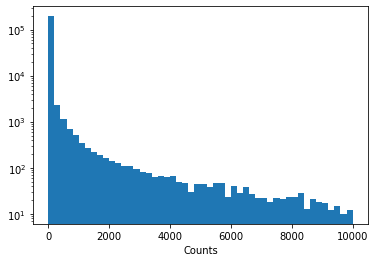

In [21]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [23]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [key for key in token_counts.keys() if token_counts[key] >= min_count]

# Add a special tokens for unknown and empty  words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [24]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [25]:
index = np.arange(len(tokens))
zip_list = zip(tokens,index)
token_to_id = dict(zip_list)

In [26]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [27]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [28]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [29]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [30]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [31]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [32]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[ 1414,    15, 14259,   733,   657,  1394,    15,   354,    57,
           278],
        [ 6115,    38,   101,  3113,    23,   214,    73,   561,  1588,
           101],
        [ 1675,   442,   558,  2133,   561,   345,   442,    57,  1675,
           111]], dtype=int32),
 'Log1pSalary': array([ 9.755103, 10.959558, 10.280999], dtype=float32),
 'Title': array([[1080,  622,    1,    1],
        [  38,  101, 3113,   23],
        [1675,  442,    1,    1]], dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [33]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [34]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.pool1(F.relu(self.conv1(h)))
        torch.flatten(h,1)
        h = F.relu(self.dense(h))
        
        return h

In [35]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [39]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
DescriptionEncoder = TitleEncoder

In [40]:
desc_encoder = DescriptionEncoder(out_size=64)
dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [44]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.categorical_encoder = nn.Sequential(    
             nn.Linear(n_cat_features, 512),
             nn.ReLU(),
             nn.Linear(512,128),
             nn.ReLU(),
             nn.Linear(128,64)
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output_layer = nn.Sequential(nn.Linear(192, 3),
                                          nn.ReLU(),
                                          nn.Linear(3,1)
                                         )

    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.categorical_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        res = self.output_layer(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return res[:,0]

In [45]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [46]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [47]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [48]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [49]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [50]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [51]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	31.83851
	MAE:	27916.32733



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.51465
	MAE:	8430.99127



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.37169
	MAE:	5905.58863



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.30499
	MAE:	5659.70494



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.25665
	MAE:	4840.80929



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.24241
	MAE:	4602.61065



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.23839
	MAE:	4561.02700



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.22638
	MAE:	4727.48343



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.21155
	MAE:	4380.91421



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.22117
	MAE:	4663.64596



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.21715
	MAE:	4444.72167



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19895
	MAE:	4176.30213



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.19620
	MAE:	4198.45868



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18741
	MAE:	4021.98007



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18601
	MAE:	4101.67077



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18166
	MAE:	4093.41896



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17771
	MAE:	4053.90092



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17678
	MAE:	3865.80224



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17004
	MAE:	4028.30820



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17569
	MAE:	3875.72928



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17925
	MAE:	3983.93201



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17664
	MAE:	3825.23619



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17988
	MAE:	4073.27907



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15854
	MAE:	3833.88359



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15722
	MAE:	3847.84281



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16527
	MAE:	3735.12368



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15023
	MAE:	3778.45280



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15695
	MAE:	3654.78966



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15320
	MAE:	3703.28022



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14726
	MAE:	3710.82657



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15071
	MAE:	3769.88988



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14461
	MAE:	3589.35525



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15052
	MAE:	3601.38408



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15097
	MAE:	3881.74678



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14349
	MAE:	3677.57901



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17301
	MAE:	3743.33696



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14346
	MAE:	3611.22245



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19971
	MAE:	4015.27698



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14677
	MAE:	3689.22127



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14535
	MAE:	3507.60074



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14398
	MAE:	3634.60470



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13123
	MAE:	3373.59126



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12827
	MAE:	3282.62288



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13005
	MAE:	3380.70156



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13784
	MAE:	3514.35532



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15935
	MAE:	3643.15785



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13115
	MAE:	3394.79508



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12540
	MAE:	3351.83789



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13335
	MAE:	3439.15404



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12635
	MAE:	3343.56422



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12622
	MAE:	3305.86295



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13441
	MAE:	3362.37588



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12145
	MAE:	3318.91821



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19582
	MAE:	4859.74423



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13615
	MAE:	3513.58279



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12188
	MAE:	3377.83454



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12105
	MAE:	3390.61353



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11734
	MAE:	3328.37359



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13630
	MAE:	3495.83606



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11497
	MAE:	3205.31378



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12351
	MAE:	3510.90933



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12387
	MAE:	3504.17569



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11980
	MAE:	3385.62668



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15324
	MAE:	3563.85925



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12156
	MAE:	3373.57049



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11618
	MAE:	3293.81547



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11723
	MAE:	3284.32866



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11433
	MAE:	3255.36404



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12004
	MAE:	3262.24410



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10987
	MAE:	3142.44743



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11730
	MAE:	3214.58421



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11987
	MAE:	3210.59555



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11470
	MAE:	3297.26051



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10757
	MAE:	3102.52023



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11384
	MAE:	3189.70473



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12074
	MAE:	3215.73282



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11370
	MAE:	3282.60646



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13004
	MAE:	3664.13155



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10707
	MAE:	3175.43789



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13736
	MAE:	3403.47628



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10790
	MAE:	3094.54625



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10245
	MAE:	3036.68392



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10467
	MAE:	3102.77409



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10035
	MAE:	2970.71764



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10746
	MAE:	3159.87247



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10675
	MAE:	3167.99026



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10917
	MAE:	3023.76190



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10847
	MAE:	3084.60568



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10837
	MAE:	3138.94930



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11271
	MAE:	3305.03739



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11590
	MAE:	3204.97942



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11980
	MAE:	3483.69655



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10756
	MAE:	3180.14297



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10018
	MAE:	3025.48906



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10806
	MAE:	3114.07046



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11907
	MAE:	3168.15767



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10466
	MAE:	3037.25474



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09822
	MAE:	2946.99958



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09880
	MAE:	3003.73015



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10231
	MAE:	3064.61140



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10116
	MAE:	3008.74542



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11416
	MAE:	3098.56569



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11183
	MAE:	3240.01132



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09822
	MAE:	2929.20723



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10239
	MAE:	3097.56035



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13288
	MAE:	3344.58927



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11374
	MAE:	3310.83536



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10275
	MAE:	3134.12357



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09922
	MAE:	3045.38954



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09799
	MAE:	3001.64714



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09946
	MAE:	3005.74133



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09660
	MAE:	2988.94473



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10400
	MAE:	3088.31200



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12097
	MAE:	3197.33299



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10244
	MAE:	3070.43123



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10179
	MAE:	2951.40673



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09995
	MAE:	3008.05247



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09311
	MAE:	2883.10599



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09172
	MAE:	2908.35016



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09346
	MAE:	2856.28718



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09905
	MAE:	3058.77743



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09571
	MAE:	2968.15162



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10288
	MAE:	3032.20136



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09256
	MAE:	2852.45049



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09845
	MAE:	2955.97879



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15692
	MAE:	3642.11551



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09266
	MAE:	2906.22820



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10005
	MAE:	3076.80888



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10300
	MAE:	3120.19920



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10730
	MAE:	3288.42125



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11731
	MAE:	3328.04519



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12047
	MAE:	3578.83251



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09499
	MAE:	2927.15394



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09275
	MAE:	2913.19853



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09762
	MAE:	2961.39959



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12864
	MAE:	3835.06632



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09508
	MAE:	2922.74205



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09074
	MAE:	2865.09552



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08874
	MAE:	2877.75622



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11066
	MAE:	3398.91473



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08998
	MAE:	2823.53433



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08829
	MAE:	2823.52832



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09214
	MAE:	2895.83405



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10741
	MAE:	3012.99241



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08768
	MAE:	2836.24597



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11118
	MAE:	3382.91730



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10288
	MAE:	3042.04877



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09834
	MAE:	2893.21071



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08792
	MAE:	2816.59547



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09719
	MAE:	2887.05093



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09225
	MAE:	2850.17702



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08728
	MAE:	2772.51078



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08665
	MAE:	2753.03167



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09409
	MAE:	2842.88009



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09697
	MAE:	2967.50050



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09943
	MAE:	3103.30038



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08970
	MAE:	2866.11695



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08732
	MAE:	2767.77406



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09185
	MAE:	2861.07965



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08744
	MAE:	2819.45058



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09290
	MAE:	2880.80568



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14901
	MAE:	4282.14098



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09947
	MAE:	3068.54059



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09754
	MAE:	2902.94601



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08166
	MAE:	2680.43202



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09207
	MAE:	2808.53530



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08432
	MAE:	2749.79545



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08466
	MAE:	2739.05820



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08942
	MAE:	2902.64746



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09451
	MAE:	3007.21667



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10083
	MAE:	3019.00891



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08926
	MAE:	2899.09327



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08710
	MAE:	2758.33883



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08514
	MAE:	2744.69246



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08907
	MAE:	2881.94372



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08638
	MAE:	2746.14954



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08189
	MAE:	2721.50250



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08887
	MAE:	2773.25574



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09258
	MAE:	2878.66163



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08300
	MAE:	2714.94342



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08791
	MAE:	2783.06199



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08523
	MAE:	2742.15631



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08055
	MAE:	2700.01846



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08857
	MAE:	2763.04918



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08766
	MAE:	2785.35169



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09894
	MAE:	2926.21075



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08653
	MAE:	2742.75890



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08240
	MAE:	2715.96879



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08102
	MAE:	2776.43495



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09369
	MAE:	2836.34689



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08537
	MAE:	2837.19898



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08343
	MAE:	2694.91585



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07813
	MAE:	2698.16188



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08806
	MAE:	2752.47889



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08406
	MAE:	2818.04200



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10473
	MAE:	2994.71136



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08762
	MAE:	2787.38142



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09760
	MAE:	2893.17228



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08147
	MAE:	2786.63859



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08258
	MAE:	2687.38493





In [52]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08258
	MAE:	2687.38493





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...